# Code for making predictions with and without news features

## Libraries/Data required

In [52]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [53]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

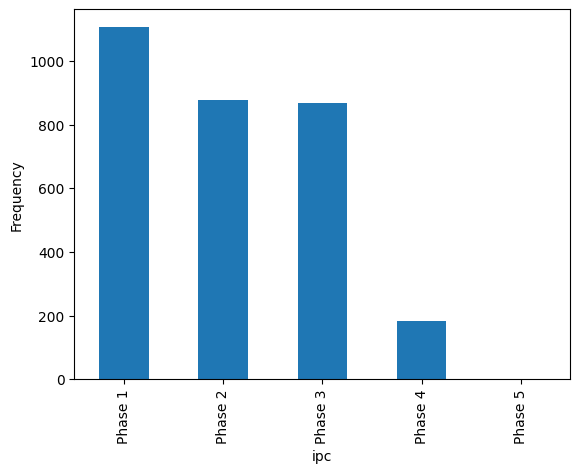

In [4]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\polus\AppData\Local\Temp\ipykernel_17520\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


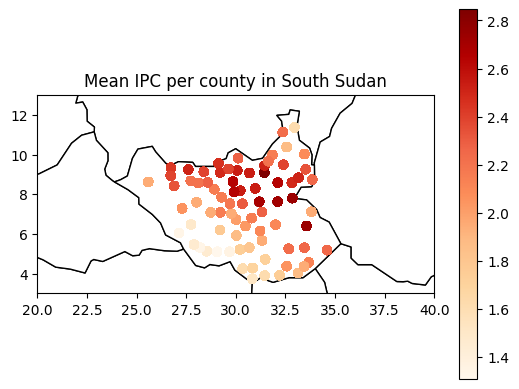

In [5]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [6]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [7]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [8]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [9]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [10]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         cropland_pct        pop  ruggedness_mean  \
date       district                                                 
2009-07-01 Abiemnhom         1.742261   20702.00        11004.640   
           Akobo            10.046920  158222.00         2787.772   
           Anzara           18.819290   76442.00        51381.880   
           Aweil Center      0.173833   48376.00         3754.860   
           Aweil East       26.804220  345977.00         3544.279   
...                               ...        ...              ...   
2020-02-01 Wulu              0.032678   45158.50        40366.550   
           Yambio           19.126490  197278.90        60628.160   
           Yei              16.303490  288875.40        75813.310   
           Yirol East        2.482445   73693.13        18421.020   
           Yirol West        0.462767  111980.60        25073.430   

                         pasture_pct  count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                                           
2009-07-01 Abiemnhom        91.48276              0.000000        95.891380   
           Akobo            89.71963              0.333333       111.870073   
           Anzara           58.21333              0.000000       103.035443   
           Aweil Center     81.76336              0.000000       106.495113   
           Aweil East       90.16216              0.000000       102.086478   
...                              ...                   ...              ...   
2020-02-01 Wulu             65.10490              0.000000       103.909292   
           Yambio           60.88350              0.500000       101.517510   
           Yei              62.85185              2.333333       102.151617   
           Yirol East       91.75000              0.166667       103.811285   
           Yirol West       87.71930              0.833333       102.977952   

                         food_price_idx_lag_3  ipc_lag_1  ipc_lag_2  ipc_lag_3  
date       district                         

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Fri, 29 Sep 2023   Prob (F-statistic):          4.40e-196
Time:                        19:58:28   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

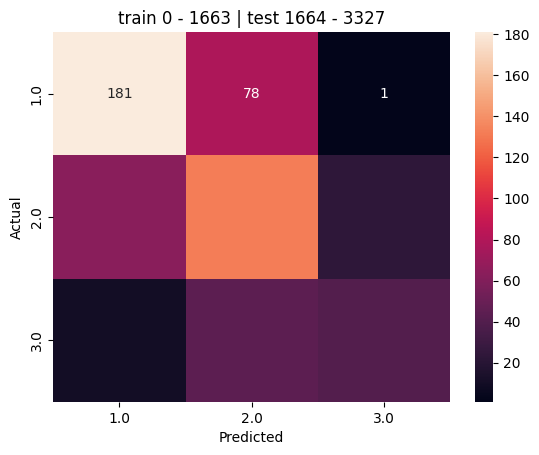

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     549.6
Date:                Fri, 29 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:58:28   Log-Likelihood:                -1508.3
No. Observations:                2626   AIC:                             3031.
Df Residuals:                    2619   BIC:                             3072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1836 

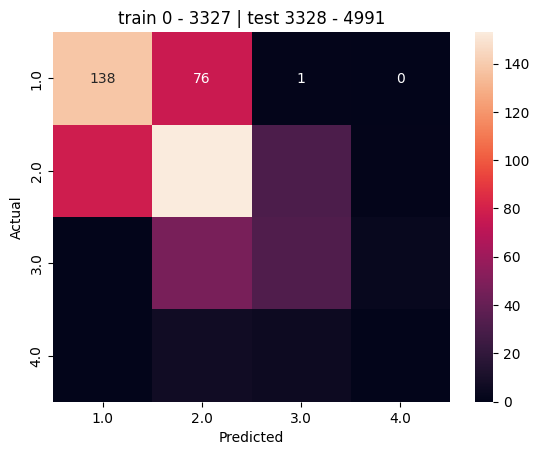

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     931.0
Date:                Fri, 29 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:58:28   Log-Likelihood:                -2591.1
No. Observations:                4290   AIC:                             5196.
Df Residuals:                    4283   BIC:                             5241.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2779 

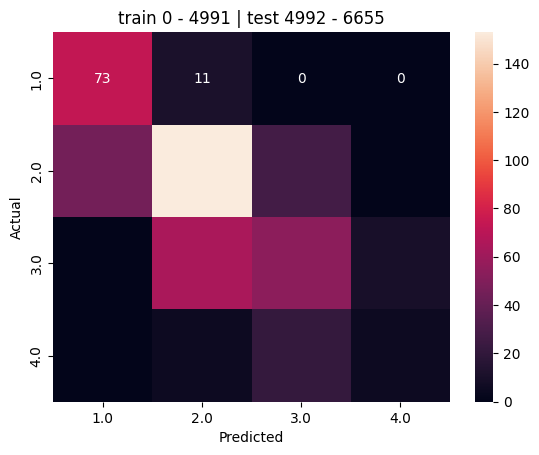

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1791.
Date:                Fri, 29 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:58:29   Log-Likelihood:                -3594.1
No. Observations:                5954   AIC:                             7202.
Df Residuals:                    5947   BIC:                             7249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2726 

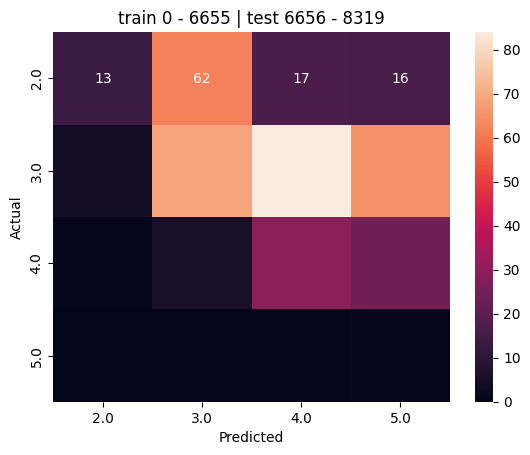

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2985.
Date:                Fri, 29 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:58:29   Log-Likelihood:                -4798.7
No. Observations:                7618   AIC:                             9611.
Df Residuals:                    7611   BIC:                             9660.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2922 

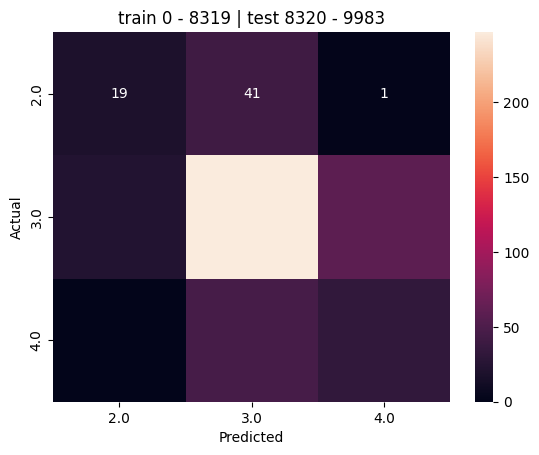

Mean MAE: 0.59
Mean R2: 0.62


<Figure size 640x480 with 0 Axes>

In [11]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [54]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,False


In [55]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)



### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [56]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])
news_features

#news_features.plot();

,hunger,refugees,conflict,humanitarian
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,0.000000,0.000000,0.0,0.050000
2023-01-01,0.000000,0.000000,0.0,0.050000
2023-02-01,0.083333,0.000000,0.0,0.069444


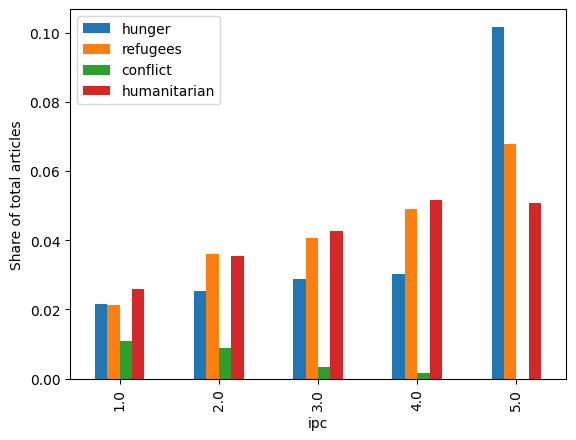

In [57]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [58]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(new_news_features, how="left") # Join df with created news features

In [59]:
df.iloc[:, -15:]

pasture_pct  hunger  conflict  humanitarian  \
date       district                                                    
2009-07-01 Abiemnhom        91.48276     NaN       NaN           NaN   
           Akobo            89.71963     NaN       NaN           NaN   
           Anzara           58.21333     NaN       NaN           NaN   
           Aweil Center     81.76336     NaN       NaN           NaN   
           Aweil East       90.16216     NaN       NaN           NaN   
...                              ...     ...       ...           ...   
2020-02-01 Wulu             65.10490     0.0  0.010753      0.022247   
           Yambio           60.88350     0.0  0.010753      0.022247   
           Yei              62.85185     0.0  0.010753      0.022247   
           Yirol East       91.75000     0.0  0.010753      0.022247   
           Yirol West       87.71930     0.0  0.010753      0.022247   

                         refugees  politics  economics  production      land  \
date       district                                                            
2009-07-01 Abiemnhom          NaN       NaN        NaN         NaN       NaN   
           Akobo              NaN       NaN        NaN         NaN       NaN   
           Anzara             NaN       NaN        NaN         NaN       NaN   
           Aweil Center       NaN       NaN        NaN         NaN       NaN   
           Aweil East         NaN       NaN        NaN         NaN       NaN   
...                           ...       ...        ...         ...       ...   
2020-02-01 Wulu               0.0       0.0    0.05673    0.022052  0.032258   
           Yambio             0.0       0.0    0.05673    0.022052  0.032258   
           Yei                0.0       0.0    0.05673    0.022052  0.032258   
           Yirol East         0.0       0.0    0.05673    0.022052  0.032258   
           Yirol West         0.0       0.0    0.05673    0.022052  0.032258   

                            pests  environment     major      topic  \
date       district                                                   
2009-07-01 Abiemnhom          NaN          NaN       NaN        NaN   
           Akobo              NaN          NaN       NaN        NaN   
           Anzara             NaN          NaN       NaN        NaN   
           Aweil Center       NaN          NaN       NaN        NaN   
           Aweil East         NaN          NaN       NaN        NaN   
...                           ...          ...       ...        ...   
2020-02-01 Wulu          0.011494     0.010753  0.022989  10.458727   
           Yambio        0.011494     0.010753  0.022989  10.458727   
           Yei           0.011494     0.010753  0.022989  10.458727   
           Yirol East    0.011494     0.010753  0.022989  10.458727   
           Yirol West    0.011494     0.010753  0.022989  10.458727   

                         sentiment  difference  
date       district                             
2009-07-01 Abiemnhom           NaN         NaN  
           Akobo               NaN         NaN  
           Anzara              NaN         NaN  
           Aweil Center        NaN         NaN  
           Aweil East          NaN         NaN  
...                            ...         ...  
2020-02-01 Wulu           0.034681    0.034681  
           Yambio         0.034681    0.034681  
           Yei            0.034681    0.034681  
           Yirol East     0.034681    0.034681  
           Yirol West     0.034681    0.034681  

[9984 rows x 15 columns]

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 29 Sep 2023   Prob (F-statistic):                nan
Time:                        20:12:07   Log-Likelihood:                -1440.9
No. Observations:                1664   AIC:                             2884.
Df Residuals:                    1663   BIC:                             2889.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5072      0.014    106.853      0.0

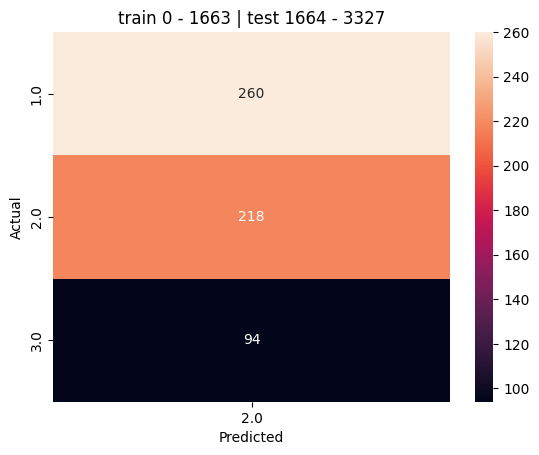

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     9.569
Date:                Fri, 29 Sep 2023   Prob (F-statistic):           3.62e-14
Time:                        20:12:07   Log-Likelihood:                -1181.4
No. Observations:                1144   AIC:                             2383.
Df Residuals:                    1134   BIC:                             2433.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6750      1.718      0.975      

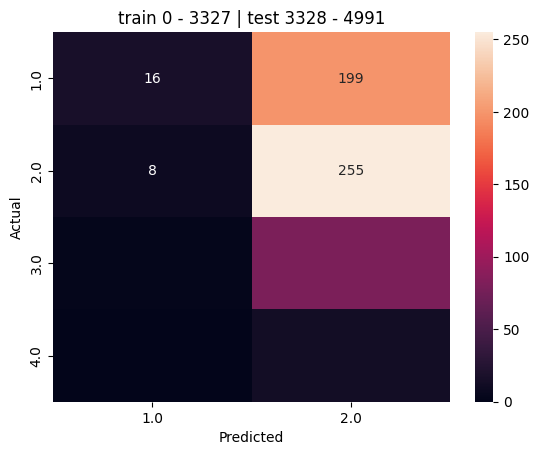

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     29.62
Date:                Fri, 29 Sep 2023   Prob (F-statistic):           9.09e-50
Time:                        20:12:07   Log-Likelihood:                -2870.7
No. Observations:                2808   AIC:                             5761.
Df Residuals:                    2798   BIC:                             5821.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9463      0.369      2.566      

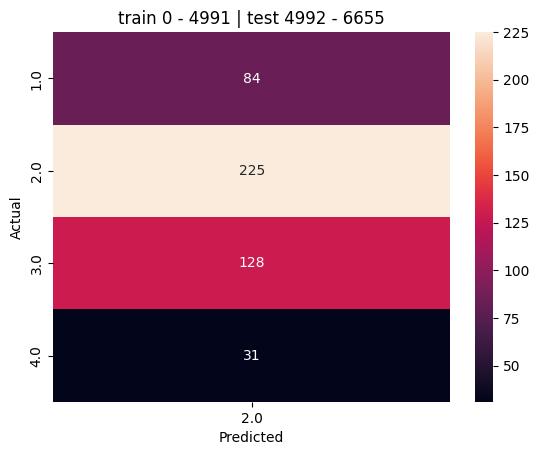

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     70.04
Date:                Fri, 29 Sep 2023   Prob (F-statistic):          2.81e-121
Time:                        20:12:08   Log-Likelihood:                -4865.3
No. Observations:                4472   AIC:                             9751.
Df Residuals:                    4462   BIC:                             9815.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3372      0.263      8.870      

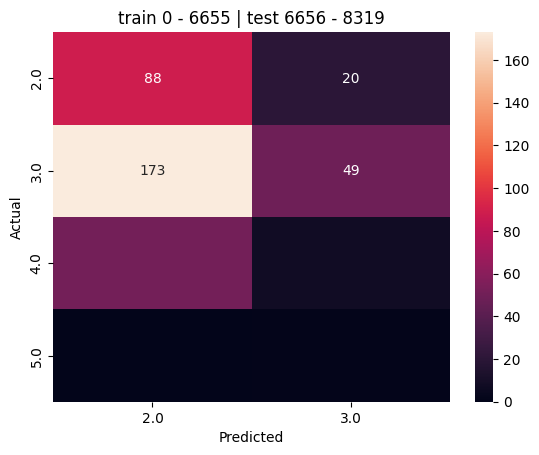

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     266.7
Date:                Fri, 29 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:12:08   Log-Likelihood:                -6630.1
No. Observations:                6136   AIC:                         1.328e+04
Df Residuals:                    6126   BIC:                         1.335e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4381      0.219      6.561      

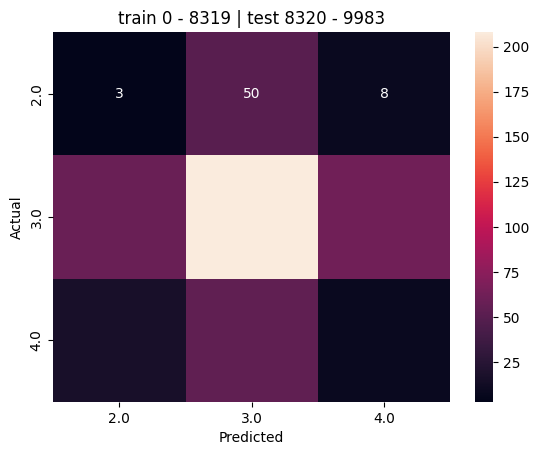

Mean MAE: 0.67
Mean R2: 0.11


<Figure size 640x480 with 0 Axes>

In [60]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

In [22]:
X.columns

Index(['const', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger',
       'refugees', 'conflict', 'humanitarian'],
      dtype='object')

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [61]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [62]:
df.iloc[:,-10:].columns

Index(['politics', 'economics', 'production', 'land', 'pests', 'environment',
       'major', 'topic', 'sentiment', 'difference'],
      dtype='object')

In [63]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

KeyError: "['ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] not in index"

### Moja zabawa z kategoriami

In [73]:
new_news_features

,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,major,topic,sentiment,difference
date,,,,,,,,,,,,,,
2011-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.022222,0.0,0.050000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000,0.000000,0.055556,12.183761,0.283412,0.283412
2023-01-01,0.022222,0.0,0.050000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000,0.055556,0.055556,13.305556,-0.021430,-0.021430
2023-02-01,0.083333,0.0,0.069444,0.000000,0.055556,0.083333,0.138889,0.083333,0.125,0.138889,0.097222,13.069444,-0.048976,-0.048976


In [72]:
new_news_df = pd.read_csv(data_dir + "topic_sentiment.csv") # Read news data into DataFrame

# Create date column
new_news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [65]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = new_news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)


In [45]:
new_news_df.drop(['tokens', 'yyyy-mm'], axis=1, inplace=True)
new_news_features = create_news_features(new_news_df.columns[5:])
new_news_df

,summary,date,location_article,lat,lng,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,major,topic,sentiment,difference
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,False,False,False,14,0.991426,0.657156
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False,False,False,False,False,False,False,False,14,-0.997186,0.657156
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False,False,False,False,False,False,False,False,1,0.982812,0.688175
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False,False,False,False,False,False,False,False,14,0.995117,0.657156
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,False,False,False,14,0.791571,0.657156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,False,False,False,False,False,False,False,14,0.999743,0.372461
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False,False,True,15,-0.865617,-0.921591
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False,False,False,False,False,False,False,False,1,0.982814,0.342806
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,False,False,False,False,False,False,False,False,14,-0.990144,0.372461


In [46]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(new_news_df.groupby(["date"])["hunger"].mean())
    .join(new_news_df.groupby(["date"])["conflict"].mean())
    .join(new_news_df.groupby(["date"])["refugees"].mean())
    .join(new_news_df.groupby(["date"])["humanitarian"].mean())
    .join(new_news_df.groupby(["date"])["politics"].mean())
    .join(new_news_df.groupby(["date"])["economics"].mean())
    .join(new_news_df.groupby(["date"])["production"].mean())
    .join(new_news_df.groupby(["date"])["land"].mean())
    .join(new_news_df.groupby(["date"])["pests"].mean())
    .join(new_news_df.groupby(["date"])["environment"].mean())
    .join(new_news_df.groupby(["date"])["major"].mean())
    
)


# Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[new_news_df.columns[5:]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );


In [67]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         politics  economics  production      land     pests  \
date       district                                                            
2009-07-01 Abiemnhom          NaN        NaN         NaN       NaN       NaN   
           Akobo              NaN        NaN         NaN       NaN       NaN   
           Anzara             NaN        NaN         NaN       NaN       NaN   
           Aweil Center       NaN        NaN         NaN       NaN       NaN   
           Aweil East         NaN        NaN         NaN       NaN       NaN   
...                           ...        ...         ...       ...       ...   
2020-02-01 Wulu               0.0    0.05673    0.022052  0.032258  0.011494   
           Yambio             0.0    0.05673    0.022052  0.032258  0.011494   
           Yei                0.0    0.05673    0.022052  0.032258  0.011494   
           Yirol East         0.0    0.05673    0.022052  0.032258  0.011494   
           Yirol West         0.0    0.05673    0.022052  0.032258  0.011494   

                         environment     major      topic  sentiment  \
date       district                                                    
2009-07-01 Abiemnhom             NaN       NaN        NaN        NaN   
           Akobo                 NaN       NaN        NaN        NaN   
           Anzara                NaN       NaN        NaN        NaN   
           Aweil Center          NaN       NaN        NaN        NaN   
           Aweil East            NaN       NaN        NaN        NaN   
...                              ...       ...        ...        ...   
2020-02-01 Wulu             0.010753  0.022989  10.458727   0.034681   
           Yambio           0.010753  0.022989  10.458727   0.034681   
           Yei              0.010753  0.022989  10.458727   0.034681   
           Yirol East       0.010753  0.022989  10.458727   0.034681   
           Yirol West       0.010753  0.022989  10.458727   0.034681   

                         difference  
date       district                

In [76]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df_new = df.join(new_news_features, how="left", lsuffix="_left", rsuffix="_right") # Join df with created news features
df_new

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         politics_right  economics_right  production_right  \
date       district                                                          
2009-07-01 Abiemnhom                NaN              NaN               NaN   
           Akobo                    NaN              NaN               NaN   
           Anzara                   NaN              NaN               NaN   
           Aweil Center             NaN              NaN               NaN   
           Aweil East               NaN              NaN               NaN   
...                                 ...              ...               ...   
2020-02-01 Wulu                     0.0          0.05673          0.022052   
           Yambio                   0.0          0.05673          0.022052   
           Yei                      0.0          0.05673          0.022052   
           Yirol East               0.0          0.05673          0.022052   
           Yirol West               0.0          0.05673          0.022052   

                         land_right  pests_right  environment_right  \
date       district                                                   
2009-07-01 Abiemnhom            NaN          NaN                NaN   
           Akobo                NaN          NaN                NaN   
           Anzara               NaN          NaN                NaN   
           Aweil Center         NaN          NaN                NaN   
           Aweil East           NaN          NaN                NaN   
...                             ...          ...                ...   
2020-02-01 Wulu            0.032258     0.011494           0.010753   
           Yambio          0.032258     0.011494           0.010753   
           Yei             0.032258     0.011494           0.010753   
           Yirol East      0.032258     0.011494           0.010753   
           Yirol West      0.032258     0.011494           0.010753   

                         major_right  topic_right  sentiment_right  \
date       district                       

In [78]:
df_new.iloc[:,-37:]
df_new.columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'hunger_left', 'conflict_left', 'humanitarian_left',
       'refugees_left', 'politics_left', 'economics_left', 'production_left',
       'land_left', 'pests_left', 'environment_left', 'major_left',
       'topic_left', 'sentiment_left', 'difference_left', 'hunger_right',
       'conflict_right', 'humanitarian_right', 'refugees_right',
       'politics_right', 'economics_right', 'production_right', 'land_right',
       'pests_right', 'environment_right', 'major_right', 'topic_right',
       'sentiment_right', 'difference_right'],
      dtype='object')

In [86]:
from sklearn.ensemble import RandomForestRegressor

2184


c:\Users\polus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


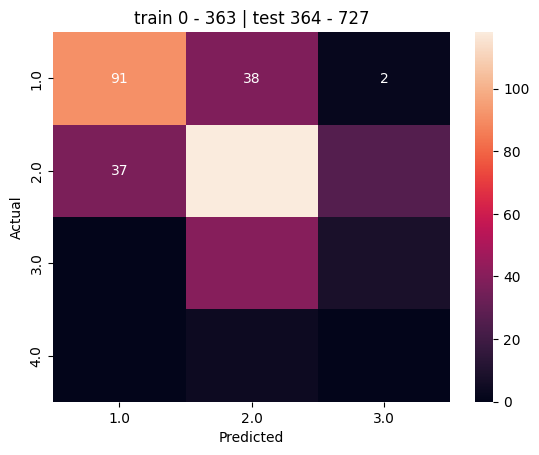

c:\Users\polus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


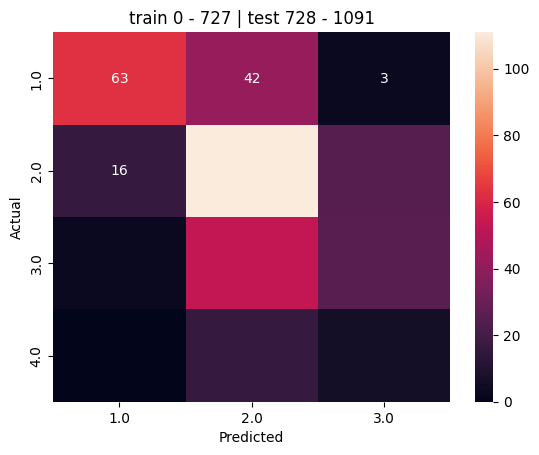

c:\Users\polus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


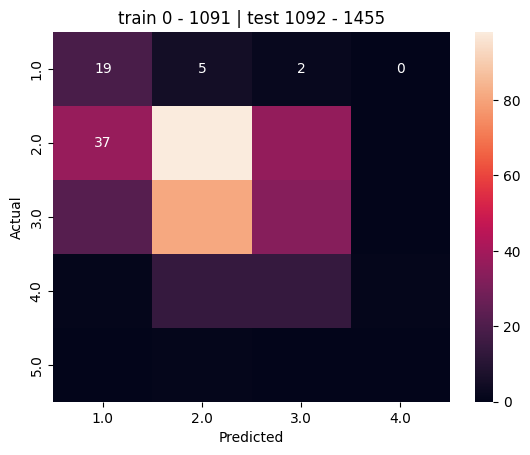

c:\Users\polus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


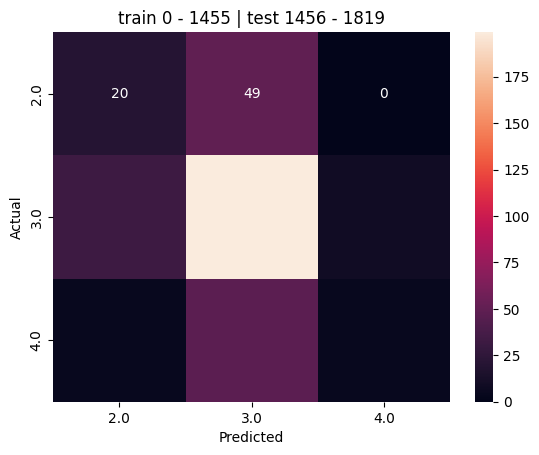

c:\Users\polus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


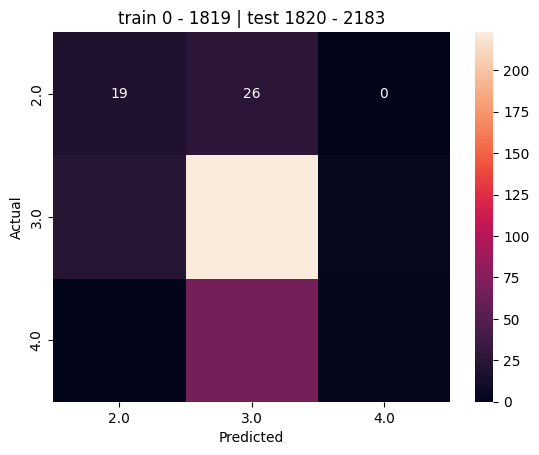

Mean MAE: 0.53
Mean R2: 0.28


<Figure size 640x480 with 0 Axes>

In [95]:
df_new_copy = df_new.copy()

df_new.dropna(inplace=True)

X = df_new.iloc[:, -37:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_new[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    X_test = X_test.dropna(axis=1, how='all').copy()
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = RandomForestRegressor() # Initialize OLS model on training data
    model.fit(X_train, y_train) # Get model results on training data

    y_pred = model.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2